In [1]:
import csv
import cv2
import time
import matplotlib.pyplot as plt
import torch
from src.model import IntRec
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from src.utils import IntImage, get_num_correct, HelperFunc


Bad key "text.kerning_factor" on line 4 in
/Users/yangzhiping/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
image_path = 'data/processed.csv'
batch_size = 8
model = IntRec()
int_image = IntImage(image_path)
image_loader = DataLoader(int_image, batch_size=8,shuffle=True)


In [3]:
batch = next(iter(image_loader))

# Example of a batch

<function matplotlib.pyplot.show(*args, **kw)>

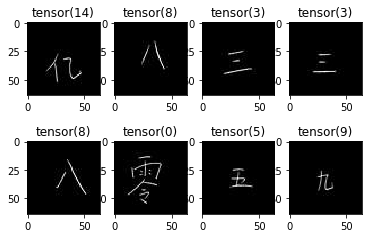

In [4]:
images = batch[0]
label = batch[1]
fig = plt.figure()
for i, image in enumerate(images):
    fig.add_subplot(2, 4, i+1)
    plt.imshow(image, cmap="gray")
    plt.title(label[i])
plt.show

In [5]:
def load_checkpoint(path, model, optimizer):
    checkpoint = torch.load(path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

In [6]:
train_size, valid_size = int(len(int_image) * 0.8), int(len(int_image) * 0.1)
test_size = len(int_image) - train_size - valid_size
train_set, valid_set, test_set = torch.utils.data.random_split(int_image, [train_size, valid_size, test_size])
train_loader = DataLoader(train_set, batch_size=8,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=8,shuffle=True)
test_loader = DataLoader(test_set, batch_size=8,shuffle=True)

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
load_checkpoint("saved_model/model1.pickle", model, optimizer)

(0.9995833333333334, tensor(1.1443, requires_grad=True))

# Some Miss Classify Example

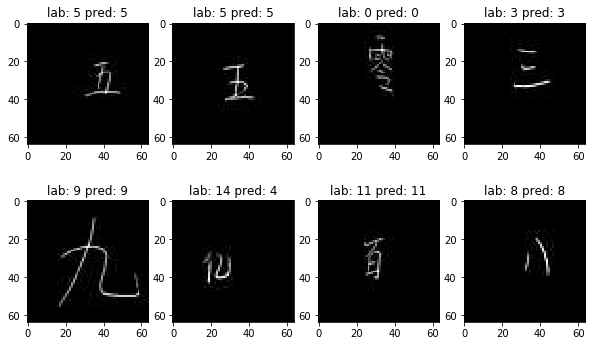

In [8]:
for i, batch in enumerate(test_loader):
    preds = model(torch.unsqueeze(batch[0], 1))
    acc = get_num_correct(preds, batch[1])
    if acc < batch_size:
        images = batch[0]
        label = batch[1]
        fig = plt.figure(figsize=[10, 6])
        for i, image in enumerate(images):
            fig.add_subplot(2, 4, i+1)
            plt.imshow(image, cmap="gray")
            plt.title(f"lab: {label[i]} pred: {preds[i].argmax(dim=0)}")
        plt.show
        break

# Test on image

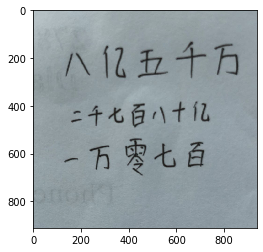

In [9]:
pic = cv2.imread('pictures/pic5.png')
plt.imshow(pic)

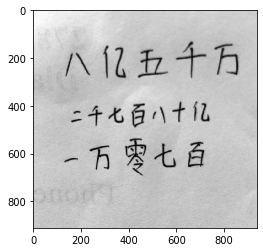

In [10]:
gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

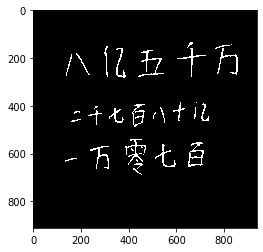

In [11]:
_, bw = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)
plt.imshow(bw, cmap="gray")

In [12]:
pic_tensor = torch.Tensor(bw)
vertical_mask = torch.ones(1, pic_tensor.size(0))
horizontal_mask = torch.ones(pic_tensor.size(1), 1)
vertical_index = torch.mm(vertical_mask, pic_tensor)
horizontal_index = torch.mm(pic_tensor, horizontal_mask)

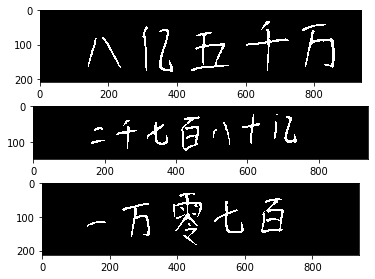

In [13]:
slices = HelperFunc.get_slices((horizontal_index != 0).view(-1))
fig = plt.figure(figsize=[6, 1.5*len(slices)])
for i, slice in enumerate(slices):
    fig.add_subplot(len(slices), 1, i+1)
    start_index, end_index = slice
    buff = int(0.2 * (end_index - start_index))
    short_pic_tensor = pic_tensor[start_index-buff : end_index + buff, : ]
    plt.imshow(short_pic_tensor, cmap="gray")

In [19]:
example_slice = pic_tensor[slices[0][0] : slices[0][1], : ]
cuts = HelperFunc.get_characters(example_slice)
fig = plt.figure(figsize=[2 * len(cuts), 2])
for i, cut in enumerate(cuts):
    fig.add_subplot(1, len(cuts), i+1)
    start_index, end_index = cut
    buff = int(0.2 * (end_index - start_index))
    short_pic_tensor = example_slice[: ,start_index-buff : end_index + buff]
    resized=F.upsample(torch.unsqueeze(short_pic_tensor, 1), size=(64,64), mode='linear')
    plt.imshow(resized, cmap="gray")

RuntimeError: It is expected output_size equals to 1, but got size 2

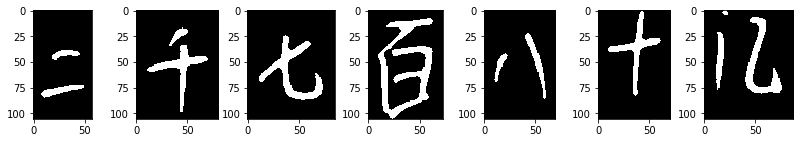

In [15]:
example_slice = pic_tensor[slices[1][0] : slices[1][1], : ]
cuts = HelperFunc.get_characters(example_slice)
fig = plt.figure(figsize=[2 * len(cuts), 2])
for i, cut in enumerate(cuts):
    fig.add_subplot(1, len(cuts), i+1)
    start_index, end_index = cut
    buff = int(0.2 * (end_index - start_index))
    short_pic_tensor = example_slice[: ,start_index-buff : end_index + buff]
    plt.imshow(short_pic_tensor, cmap="gray")

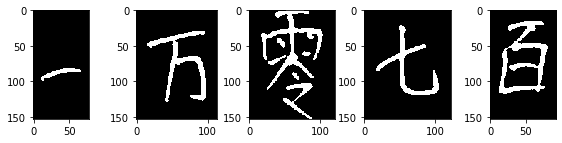

In [16]:
example_slice = pic_tensor[slices[2][0] : slices[2][1], : ]
cuts = HelperFunc.get_characters(example_slice)
fig = plt.figure(figsize=[2 * len(cuts), 2])
for i, cut in enumerate(cuts):
    fig.add_subplot(1, len(cuts), i+1)
    start_index, end_index = cut
    buff = int(0.2 * (end_index - start_index))
    short_pic_tensor = example_slice[: ,start_index-buff : end_index + buff]
    plt.imshow(short_pic_tensor, cmap="gray")